In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        pass
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
#在模型中必须要定义forward函数，backward函数(反向传播算法--计算梯度)会被autograd自动创建。

params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [3]:
net.conv1

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))

In [4]:
rnn = torch.nn.RNN(20, 50, 2)
input = torch.randn(100, 32, 20)
h_0 = torch.randn(2, 32, 50)
output, hn = rnn(input, h_0)
print(output.size(), hn.size())

torch.Size([100, 32, 50]) torch.Size([2, 32, 50])


In [6]:
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [7]:
##RNN 超差数
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28    ##时间步，在这里是图片的 高度维度
INPUT_SIZE = 28    ##输入值，维度
LR = 0.01   ## 学习率



In [10]:
# Mnist 手写数字
train_data = dsets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=True,          # 没下载就下载, 下载了就不用再下了
)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


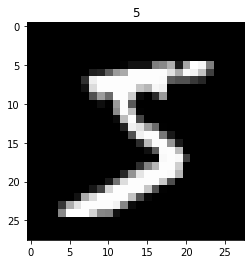

In [12]:
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('{}'.format(train_data.train_labels[0]))
plt.show()

In [13]:
test_data = dsets.MNIST(root='./mnist', train=False)

##批训练， 50 samples， 1channel， 28x28(50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#测试集
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.test_labels[:2000]

/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:
###建立RNN模型
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size=28,  ##图片每行的数据像素点
            hidden_size=64,  ##rnn的隐藏层单元
            num_layers=1,  ##有几层rnn
            batch_first=True
        )
        
        
        self.out = nn.Linear(64, 10)
    
    
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        
        ##选取最后一个时间点的r_out，因为是图片所以最最后一次输出分类即可
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [45]:
##训练
##将图片看成一个时间上的连续数据，每一行的像素点都是这个时刻的输入，读完整张图片就是从上而下的读完了每行的像素点，然后我们就可以拿出RNN在最后一步分析

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss() ##交叉熵


for epoch in range(4):
    for step, (x, b_y) in enumerate(train_loader):
        b_x = x.view(-1, 28, 28)
        
        output = rnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad() ##将这个时间步的梯度清除
        loss.backward()
        optimizer.step()
        
        
        if step % 50 == 0:
            test_output = rnn(test_x)  ##训练50次计算一次模型的准确率                  # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.numpy()).astype(int).sum()) / float(test_y.numpy().size)
            print('Epoch:{}\|train loss: {:.4f}\| test accuracy: {:.2f}'.format(epoch,loss.data.numpy(), accuracy))

Epoch:0\|train loss: 0.1237\| test accuracy: 0.94
Epoch:0\|train loss: 0.2263\| test accuracy: 0.95
Epoch:0\|train loss: 0.1900\| test accuracy: 0.94
Epoch:0\|train loss: 0.1087\| test accuracy: 0.96
Epoch:0\|train loss: 0.2633\| test accuracy: 0.95
Epoch:0\|train loss: 0.2536\| test accuracy: 0.96
Epoch:0\|train loss: 0.1493\| test accuracy: 0.96
Epoch:0\|train loss: 0.2276\| test accuracy: 0.96
Epoch:0\|train loss: 0.1125\| test accuracy: 0.96
Epoch:0\|train loss: 0.0796\| test accuracy: 0.96
Epoch:0\|train loss: 0.0391\| test accuracy: 0.97
Epoch:0\|train loss: 0.0498\| test accuracy: 0.97
Epoch:0\|train loss: 0.0445\| test accuracy: 0.96
Epoch:0\|train loss: 0.0374\| test accuracy: 0.96
Epoch:0\|train loss: 0.0957\| test accuracy: 0.96
Epoch:0\|train loss: 0.1717\| test accuracy: 0.97
Epoch:0\|train loss: 0.2981\| test accuracy: 0.96
Epoch:0\|train loss: 0.0631\| test accuracy: 0.96
Epoch:0\|train loss: 0.0482\| test accuracy: 0.97
Epoch:1\|train loss: 0.0859\| test accuracy: 0.96


In [46]:
test_output = rnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, '预测数字')
print(test_y[:10], '真实数字')

[7 2 1 0 4 1 4 9 5 9] 预测数字
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]) 真实数字


In [49]:
import random

random.choice(test_x).size()

torch.Size([28, 28])

In [26]:
test_x = test_x.view(-1, 28, 28)

In [52]:
test_x[:10].size()

torch.Size([10, 28, 28])

In [53]:
pred_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[2000: 2100]/255.
real_y = test_data.test_labels[2000: 2100]

/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/lvsongke/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


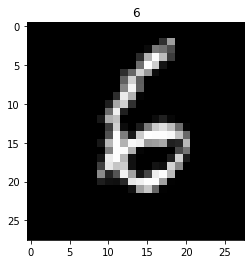

In [80]:
plt.imshow((pred_x[0][0] * 100).type(torch.uint8).numpy(), cmap='gray')
plt.title('{}'.format(real_y[0]))
plt.show()

In [73]:
train_data.train_data[0].numpy()

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [74]:
pred_x[0].type(torch.uint8).numpy()

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

In [70]:
pred_x[0].type(torch.uint8).numpy()

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

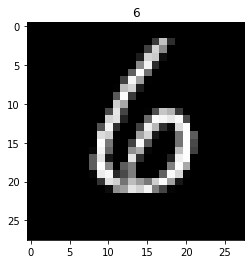

In [86]:
plt.imshow((pred_x[2][0] * 100).type(torch.uint8).numpy(), cmap='gray')
plt.title('{}'.format(real_y[2]))
plt.show()

In [81]:
%matplotlib inline

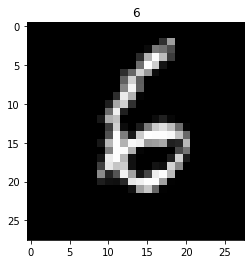

预测结果:6


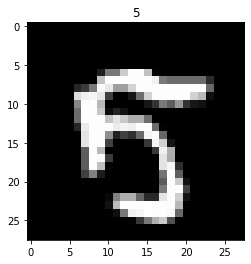

预测结果:5


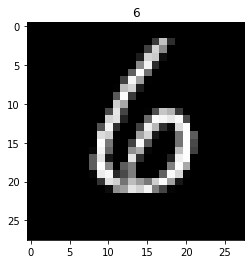

预测结果:6


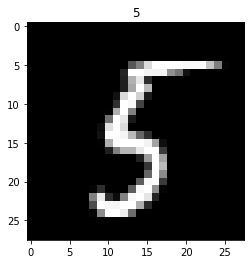

预测结果:5


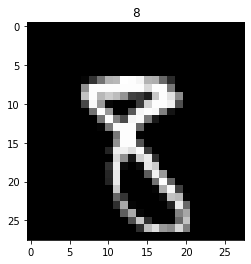

预测结果:8


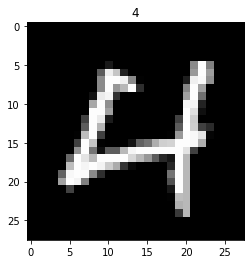

预测结果:4


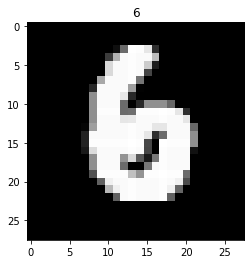

预测结果:6


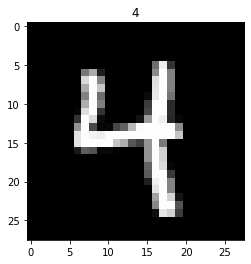

预测结果:4


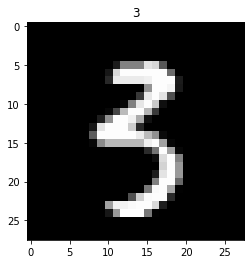

预测结果:3


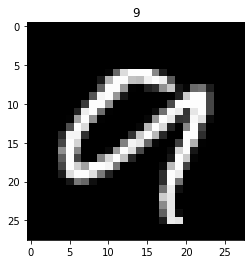

预测结果:9


In [95]:
for i in range(10):
    plt.imshow((pred_x[i][0] * 100).type(torch.uint8).numpy(), cmap='gray')
    plt.title('{}'.format(real_y[i]))
    plt.show()
    test_output = rnn(pred_x[i])
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    print('预测结果:{}'.format(pred_y))

In [89]:
###RNN  回归，
##用sin预测cos

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [90]:
###定义超参数
TIME_STEP = 10  ##隐藏层数
INPUT_SIZE = 1 ##输入维度
LR = 0.02   #学习率

In [92]:
class Sin2Cos(nn.Module):
    def __init__(self):
        super(Sin2Cos, self).__init__()
        
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Linear(32, 1)
        
    def forward(self, x, h_state): ##因为hidden state 是连续的，所以我们要一只传递这个state
        r_out, h_state = self.rnn(x, h_state) ##作为rnn的输入
        r_out = r_out.view(-1, 32)
        outs = self.out(r_out)
        return outs.view(-1, 32, TIME_STEP), h_state

sin2cos = Sin2Cos()
print(sin2cos)

Sin2Cos(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [94]:
optimizer = torch.optim.Adam(sin2cos.parameters(), lr=LR)
loss_sin_func = nn.MSELoss

h_state = None

for step in range(100):
    start, end = step * np.pi, (step + 1) *np.pi
    # 创建训练集
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32, endpoint=False)
    x_np = np.sin(steps)
    y_np = np.cos(steps)
    
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    
    print(x)
    
    prediction, h_state = sin2cos(x, h_state)
    
    h_state = h_state.data
    
    loss = loss_sin_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    

tensor([[[0.0000],
         [0.3090],
         [0.5878],
         [0.8090],
         [0.9511],
         [1.0000],
         [0.9511],
         [0.8090],
         [0.5878],
         [0.3090]]])


RuntimeError: shape '[-1, 32, 10]' is invalid for input of size 10